In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.misc
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import time
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import cv2
import pickle

In [2]:
device = torch.device('cpu')

In [3]:
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model, dataloader):   
    model.eval()
    y_test_label = []
    y_test = []
    y_score = []
    pre = []
    for i, (data) in enumerate(dataloader):
        image = data['x'].to(device,dtype=torch.float)
        label = data['y'].to('cpu',dtype=torch.long)
        y_test_label = y_test_label+label.tolist()
        label = label_binarize(label, classes=[0, 1, 2])
        if y_test == []:
            y_test=label
        else:
            y_test = np.concatenate((y_test,label),axis = 0)
        output = model(image)
        output = F.softmax(output,dim=1)
        output = output.to('cpu')
        if y_score == []:
            y_score=np.array(output.detach().numpy())
        else:
            y_score = np.concatenate((y_score,output.detach().numpy()),axis = 0)
    for i in y_score:
        pre.append(list(i).index(max(i)))
    return y_test_label,y_test,pre,y_score

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    #print(cm.shape)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(-0.5, cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return None

In [4]:
f=open('./Python File/model_eval.txt','rb')
save_dict = pickle.load(f)  
f.close()

In [5]:
y_test_label = save_dict['y_test_label']
y_test = save_dict['y_test']
pre = save_dict['pre']
y_score = save_dict['y_score']

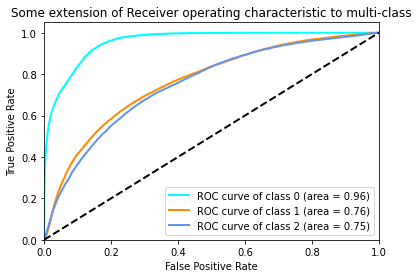

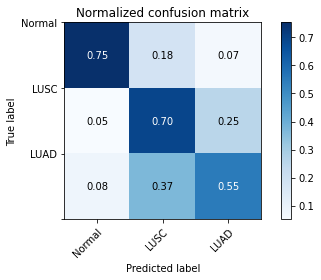

In [6]:
ROC_curve(y_test,y_score)
classes = ['Normal','LUSC','LUAD']
plot_confusion_matrix(y_test_label, pre, classes)

In [7]:
test_subimages_df_path = '/scratch/cz2064/myjupyter/BDML/Project/Phase5/Train_Test_Split/test_subimages.csv'
test_subimages_df = pd.read_csv(test_subimages_df_path)
test_subimages_df

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,Level Dimensions,type,label,Subimage File
0,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,"((16000, 11875), (4000, 2968))",Tumor-LUSC,1,subsample_1_1.jpg
1,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,"((16000, 11875), (4000, 2968))",Tumor-LUSC,1,subsample_1_2.jpg
2,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,"((16000, 11875), (4000, 2968))",Tumor-LUSC,1,subsample_1_3.jpg
3,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,"((16000, 11875), (4000, 2968))",Tumor-LUSC,1,subsample_1_4.jpg
4,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,"((16000, 11875), (4000, 2968))",Tumor-LUSC,1,subsample_2_1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...
60545,074c22a8-5175-41e7-a0e4-2fbc1871b4cf,TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98b...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-5930,TCGA-50-5930-01A,Primary Tumor,"((51793, 36328), (12948, 9082), (3237, 2270))",Tumor-LUAD,2,subsample_23_15.jpg
60546,074c22a8-5175-41e7-a0e4-2fbc1871b4cf,TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98b...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-5930,TCGA-50-5930-01A,Primary Tumor,"((51793, 36328), (12948, 9082), (3237, 2270))",Tumor-LUAD,2,subsample_23_16.jpg
60547,074c22a8-5175-41e7-a0e4-2fbc1871b4cf,TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98b...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-5930,TCGA-50-5930-01A,Primary Tumor,"((51793, 36328), (12948, 9082), (3237, 2270))",Tumor-LUAD,2,subsample_24_12.jpg
60548,074c22a8-5175-41e7-a0e4-2fbc1871b4cf,TCGA-50-5930-01A-01-TS1.a03e43a6-cac8-4a5d-98b...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-5930,TCGA-50-5930-01A,Primary Tumor,"((51793, 36328), (12948, 9082), (3237, 2270))",Tumor-LUAD,2,subsample_24_15.jpg


In [8]:
test_df_path = '/scratch/cz2064/myjupyter/BDML/Project/Phase5/Train_Test_Split/test.csv'
test_df = pd.read_csv(test_df_path)
test_df

,File ID,File Name,Data Category,Data Type,Project ID,Case ID,Sample ID,Sample Type,type,label
0,b05abef8-826a-4381-88a4-9920b2df8d3f,TCGA-60-2725-01A-01-TS1.47dfda47-c072-46cb-80d...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2725,TCGA-60-2725-01A,Primary Tumor,Tumor-LUSC,1
1,7dd02309-79ba-450f-8b13-789dbb8fb61a,TCGA-60-2710-11A-01-BS1.570f0c48-7d79-4fe3-927...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-60-2710,TCGA-60-2710-11A,Solid Tissue Normal,Normal,0
2,7aed21df-98a3-49d9-b4b8-c06c432e62bf,TCGA-44-2657-11A-01-TS1.03d328d6-5c0e-42ec-90b...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-44-2657,TCGA-44-2657-11A,Solid Tissue Normal,Normal,0
3,0aebe9e5-eaa9-46dd-ad7b-7d0b06c13b8d,TCGA-66-2780-01A-01-BS1.75a3754a-e4d2-4ef8-ba3...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-66-2780,TCGA-66-2780-01A,Primary Tumor,Tumor-LUSC,1
4,c21f3186-f757-40e9-a576-91ce0a7bfe58,TCGA-94-A5I4-01A-01-TS1.F254FD92-09AE-42D5-AE3...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-94-A5I4,TCGA-94-A5I4-01A,Primary Tumor,Tumor-LUSC,1
...,...,...,...,...,...,...,...,...,...,...
411,dd76a429-9fc2-47db-8ebc-8d6dda0bc99d,TCGA-50-6590-11A-01-TS1.fefe9444-70ce-4911-a03...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-50-6590,TCGA-50-6590-11A,Solid Tissue Normal,Normal,0
412,18f7943d-6a38-4ebc-ab56-354b4980c96a,TCGA-37-4135-01A-01-TS1.fd901f17-fe66-4709-b28...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-37-4135,TCGA-37-4135-01A,Primary Tumor,Tumor-LUSC,1
413,05919b71-18da-47b5-b5fb-af3ff07a871a,TCGA-78-7163-11A-01-TS1.1ce6c71a-1466-48d2-89d...,Biospecimen,Slide Image,TCGA-LUAD,TCGA-78-7163,TCGA-78-7163-11A,Solid Tissue Normal,Normal,0
414,08172153-d520-4d0d-9291-faebfbd4d92d,TCGA-56-8307-01A-01-TS1.7537de75-53be-4ace-aec...,Biospecimen,Slide Image,TCGA-LUSC,TCGA-56-8307,TCGA-56-8307-01A,Primary Tumor,Tumor-LUSC,1


In [9]:
samples_score = []
for idx in test_df.index:
    file_id = test_df.loc[idx,'File ID']
    file_name = test_df.loc[idx,'File Name']
    subimages_index_list = test_subimages_df.loc[test_subimages_df['File Name'] == file_name].index.tolist()
    subimages_scores = y_score[subimages_index_list[0]:subimages_index_list[-1]+1]
    whole_image_score = np.array([np.mean(subimages_scores,axis=0)])
    if samples_score == []:
        samples_score = whole_image_score
    else:
        samples_score = np.concatenate((samples_score,whole_image_score),axis=0)

In [10]:
samples_label = label_binarize(test_df['label'].values, classes=[0, 1, 2])

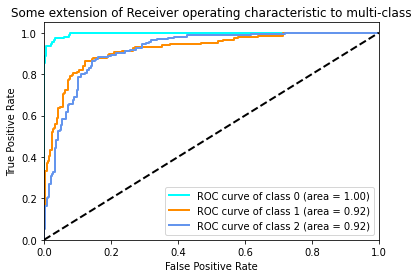

In [11]:
ROC_curve(samples_label,samples_score)

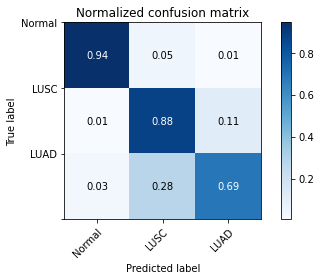

In [12]:
test_label = test_df['label'].values.tolist()
pre = []
for i in samples_score:
    pre.append(list(i).index(max(i)))
classes = ['Normal','LUSC','LUAD']
plot_confusion_matrix(test_label, pre, classes)

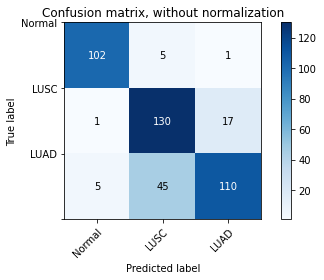

In [14]:
plot_confusion_matrix(test_label, pre, classes,normalize=False)

In [1]:
!pwd

/scratch/cz2064/myjupyter/BDML/Project/Phase5/Jupyter_Notebook/Analysis_2
